# *MCEN90048 - EEG Grasp-and-Lift Detection*

# Code: Data Visualisation and Preprocessing

**Group 1:**
- Tuan Khoi Nguyen
- Fawad Ahmed Malik
- Sean Breukel
- Victor Bouchet-Hibbert

For detailed description, please refer to `README.md`.

---
---

### Environment check, data downloading

In [ ]:
import os
import json
import zipfile
from pathlib import Path

try:
  # See if you are running on colab
  from google.colab import drive 
  # Mount with your google drive can save up redownloading data every time
  drive.mount('/content/gdrive', force_remount=True)
  path = "gdrive/MyDrive/MCEN90048/Assignment 3 Resources"
  os.chdir(path)

  # Download the dataset to Virtual Machine if the folder is not there already
  if not os.path.isdir('train'):
    api_token = {"username":"tuankhoinguyen","key":"6b992b229c6a4d8f6a8b30d1c101507d"}
    kaggle_path = Path('/root/.kaggle')
    os.makedirs(kaggle_path, exist_ok=True)

    with open (kaggle_path/'kaggle.json', 'w') as handl:
        json.dump(api_token,handl)
    os.chmod(kaggle_path/'kaggle.json', 600)  
    !kaggle competitions download -c grasp-and-lift-eeg-detection

    # Unzipping datasets
    for z in ['grasp-and-lift-eeg-detection','train','test']:
      print(f'Unzipping {z}.zip')
      with zipfile.ZipFile(f'{z}.zip', 'r') as zip_ref:
        zip_ref.extractall('')
    print('All good!')
    # Removing the zip files to save up Virtual Machine space
    !rm *.zip
except:
  # If you are running on local, 
  # - Assume here that you have 'train' and 'test' on same directory
  # - If not, consider using os.chdir()
  print(os.getcwd())

Mounted at /content/gdrive


In [ ]:
# Import necessary libraries for this notebook
import glob
import tqdm
import pywt
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

---
## Data observation & visualisation

In [ ]:
# List out all train data files
datas = glob.glob('/train/*_data.csv')
# List out all train event files
events = glob.glob('/train/*_events.csv')
# List out all test data files
tests = glob.glob('/test/*.csv')

### Label (events) inspection

In [ ]:
# Count up all occurrence of activities in the training dataset
df_count = pd.DataFrame()

for e in tqdm.tqdm(events):
  df = pd.read_csv(e).iloc[:,1:]
  ct = df.value_counts()
  df_count = ct if df_count.empty else df_count.add(ct, fill_value=0)

df_count = df_count.reset_index(name='count').astype(int)
df_count['No. Activities'] = df_count.iloc[:,:-1].sum(axis=1)
df_count

100%|██████████| 96/96 [00:24<00:00,  3.96it/s]


,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased,count,No. Activities
0,0,0,0,0,0,0,15687584,0
1,0,0,0,0,0,1,321905,1
2,0,0,0,0,1,0,321905,1
3,0,0,0,0,1,1,146095,2
4,0,0,0,1,0,0,388279,1
5,0,0,1,0,0,0,134690,1
6,0,0,1,1,0,0,49296,2
7,0,1,0,0,0,0,184452,1
8,0,1,0,1,0,0,204,2
9,0,1,1,0,0,0,253123,2


In [ ]:
# Count the number of frames where multiple activities happened
df_stats = df_count.groupby('No. Activities')['count'].sum().reset_index(name='Count (frames)')
df_stats

,No. Activities,Count (frames)
0,0,15687584
1,1,1819231
2,2,448718
3,3,30221


### Visualise signals

In [ ]:
# Read in a sample series and its event: Subject 3, Series 5
d = pd.read_csv('train/subj3_series5_data.csv').iloc[:,1:]
e = pd.read_csv('train/subj3_series5_events.csv')

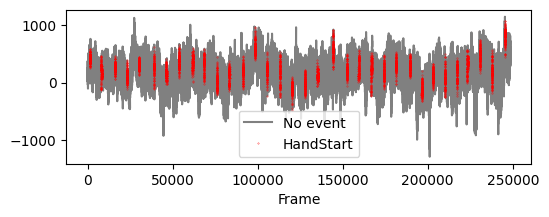

In [ ]:
# Displaying a sample channel
signal = d['O1']
idx = e[e['HandStart']==1].index
_,ax = plt.subplots(figsize = (6,2))
ax.plot(signal, 'gray')
ax.plot(idx,signal[idx], 'red', linestyle='None', marker='.', markersize=0.5)
ax.legend(['No event', 'HandStart'])
ax.set_xlabel('Frame')
plt.show()

In [ ]:
# Display some feature distributions
pd.DataFrame({'Minimum':d.min(),'Maximum':d.max(),'Mean':d.mean(),'Standard Deviation':d.std()}).sample(5)

,Minimum,Maximum,Mean,Standard Deviation
FC6,-476,919,278.267371,137.911623
FC2,-490,224,-98.334672,90.307333
T7,-1034,593,-222.679928,208.111260
Pz,-757,1146,218.579583,213.857836
CP6,-906,752,-37.539353,170.733517


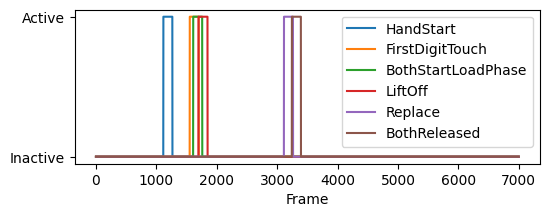

In [ ]:
# Displaying the events in the first 7000 frames
_,ax = plt.subplots(figsize=(6,2))
for c in e.columns[1:]:
  ax.plot(e[c][:7000])
ax.legend(e.columns[1:])
ax.set_yticks([0,1])
ax.set_yticklabels(['Inactive', 'Active'])
ax.set_xlabel('Frame')
plt.show()

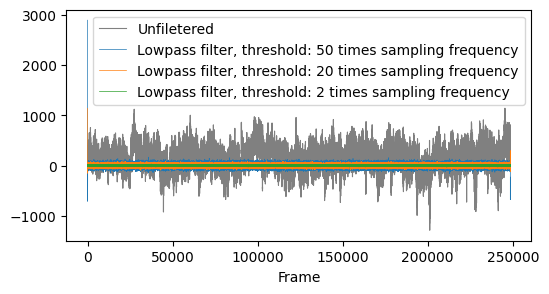

In [ ]:
# Applying lowpass filter to the signal
_,ax = plt.subplots(figsize=(6,3))
ax.plot(signal,'gray',linewidth=0.8)
# Frequency threshold multiplier (times sampling frequency)
T = [50,20,2]
# Sampling frequency in Hz
freq = 500
lg = ['Unfiletered']

# Trying different lowpass thresholds
for t in T:
  f = np.fft.fft(signal)
  f = np.fft.fftshift(f)
  f[(f>freq*t)] = 0
  new_f = np.fft.ifft(f)
  ax.plot(new_f, linewidth=0.5)
  lg.append(f'Lowpass filter, threshold: {t} times sampling frequency')

# Touch up plot
ax.set_xlabel('Frame')
ax.legend(lg)
plt.show()

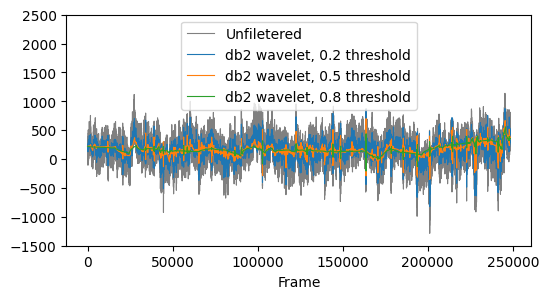

In [ ]:
# Applying wavelet transform to the signal
_,ax = plt.subplots(figsize=(6,3))
ax.plot(signal,'gray',linewidth=0.8)
# Wavelet thresholds
T=[0.2,0.5,0.8]
# Wavelet type
w='db2'
lg = ['Unfiletered']

# Trying different thresholds
for t in T:
  coeffs = pywt.wavedec(signal,w)
  new_c = [pywt.threshold(c, t*max(c)) if i else c for i,c in enumerate(coeffs)]
  rec = pywt.waverec(new_c,w)
  ax.plot(rec,linewidth=0.8)
  lg.append(f'{w} wavelet, {t} threshold')

# Touch up plot
ax.set_xlabel('Frame')
ax.set_ylim([-1500,2500])
ax.legend(lg)
plt.show()

---
## Data preprocessing

<Axes: >

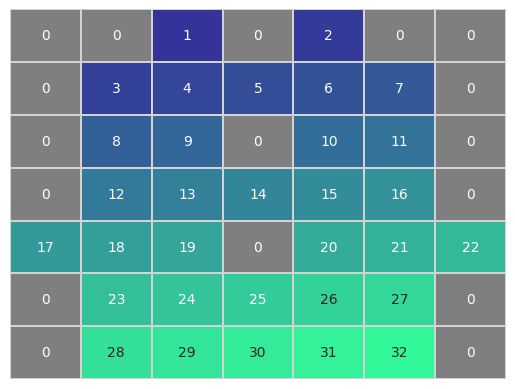

In [ ]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# The intended visualisation used for CNN
output_layout = np.array([[0, 0, 1, 0, 2, 0, 0],
                          [0, 3, 4, 5, 6, 7, 0],
                          [0, 8, 9, 0,10,11, 0],
                          [0,12,13,14,15,16, 0],
                          [17,18,19,0,20,21,22],
                          [0,23,24,25,26,27, 0],
                          [0,28,29,30,31,32, 0]])
output_layout_flattened = output_layout.flatten()

# Visualize the intended arrangement: Gray = 0 value, Blue/Cyan/Green = features
myColors = [(0.0, 0.0, 0.0, 0.5)] + [(0.0, i/32, 0.5, 0.8) for i in range(32)]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.heatmap(output_layout, annot=True, cmap=cmap,
            cbar=False, xticklabels=False, yticklabels=False, 
            linecolor='lightgray', linewidths=.2)

In [2]:
def preprocess(data: str, 
               is_train: bool, 
               dir: str='out', 
               T: float=0.1, 
               scale: bool=True,
               scaler_dict: dict = None) -> None:
  r''' Preprocess data and export to the specified location.

  Parameters
  ---
  - `data`: name of data file name
  - `is_train`: whether data belongs to train or test set
  - `dir`: directory to export the processed data to
  - `T`: Wavelet threshold. The larger threshold the more details removed
  - `scale`: If standardization is to be used
  - `scale_dict`: dictionary of scalers for each subject
  '''

  # Read in file
  fname = data.split('/')[-1][:-4]
  df = pd.read_csv(data).iloc[:,1:]
  l = len(df)

  # Perform wavelet thresholding
  out = pd.DataFrame()
  for c in df.columns:
    coeffs = pywt.wavedec(df[c],w)
    new_c = [pywt.threshold(co, T*max(co)) if i else co for i,co in enumerate(coeffs)]
    out[c] = pywt.waverec(new_c,w)

  # If standardization is to be used (assuming only train data is put to this function)
  if scale: 
    subject_number = fname.split('_')[0]
    # If train data: create a scaler and add to dictionary
    if is_train: 
      scaler = StandardScaler()
      df = scaler.fit_transform(df)
      # Note: If you want to get distribution for whole subject you have to merge all series
      scaler_dict[subject_number] = scaler
    # If test data: transform from the train scaler to avoid data leakage
    else:
      try:
        scaler = scaler_dict[subject_number]
        df = scaler.transfrom(df)
      except:
        # In case of failure, no scaling
        print('Cannot transform test set. Exporting unscaled data instead.')

  # Map and rearrange each time frame into 7x7 image
  img = np.c_[[out.iloc[:l,i-1] if i else np.zeros(l) for i in output_layout_flattened]].T.reshape(-1,7,7)

  # Save to the output folder: 1x32 format and 7x7 format
  np.save(f'{dir}/7x7/{fname}.npy',img)
  out.to_csv(f'{dir}/raw/{fname}.csv')

*Note: In case you want to rerun this cell, it should take roughly 30 minutes per threshold.*

In [ ]:
# 2nd-order Daubechies wavelet
w='db2'
# 4 thresholding values to be tested
Ts = [0.15,0.3,0.5,0.8]

# Perform processing on train and test dataset, on different wavelet thresholds
for dataset, name in zip([datas,tests],['train','test']):
  for T in Ts:
    # Make directories
    dir = f'fil{100*Ts:d}_{name}'
    os.makedirs(dir+'/7x7', exist_ok=True)
    os.makedirs(dir+'/raw', exist_ok=True)
    # Iterate through all datasets
    for d in tqdm.tqdm(dataset):
      preprocess(d, name=='train', dir, T, False)